## Basic KB-NUFFT Example

This notebook implements a basic KB-NUFFT example. It takes a Shepp-Logan phantom, applies the forward NUFFT, and then the adjoint NUFFT. An alternative processing path is to apply the density compensation function prior to adjoint NUFFT. Both of these examples are included here.

### Note

This notebook uses the shepp_logan_phantom from scikit-image, which is included in scikit-image v0.16. The standard Anaconda scikit-image as of this writing is 0.15. To use this notebook, you'll need to upgrade scikit-image to v0.16, e.g. ```conda install -c conda-forge scikit-image=0.16```.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from torchkbnufft import KbNufft, AdjKbNufft
from torchkbnufft.mri.dcomp_calc import calculate_radial_dcomp_pytorch
from torchkbnufft.math import absolute

dtype = torch.float

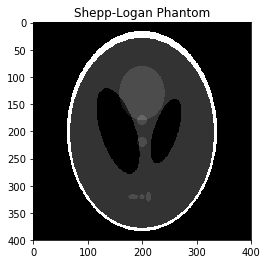

In [2]:
# create a simple shepp logan phantom and plot it
image = shepp_logan_phantom().astype(np.complex)
im_size = image.shape
plt.imshow(np.absolute(image))
plt.gray()
plt.title('Shepp-Logan Phantom')
plt.show()

In [3]:
# convert the phantom to a tensor and unsqueeze coil and batch dimension
image = np.stack((np.real(image), np.imag(image)))
image = torch.tensor(image).to(dtype).unsqueeze(0).unsqueeze(0)
print('image shape: {}'.format(image.shape))

image shape: torch.Size([1, 1, 2, 400, 400])


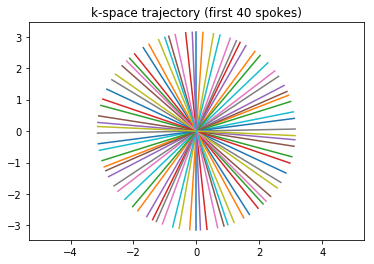

In [4]:
# create a k-space trajectory and plot it
spokelength = image.shape[-1] * 2
grid_size = (spokelength, spokelength)
nspokes = 405

ga = np.deg2rad(180 / ((1 + np.sqrt(5)) / 2))
kx = np.zeros(shape=(spokelength, nspokes))
ky = np.zeros(shape=(spokelength, nspokes))
ky[:, 0] = np.linspace(-np.pi, np.pi, spokelength)
for i in range(1, nspokes):
    kx[:, i] = np.cos(ga) * kx[:, i - 1] - np.sin(ga) * ky[:, i - 1]
    ky[:, i] = np.sin(ga) * kx[:, i - 1] + np.cos(ga) * ky[:, i - 1]
    
ky = np.transpose(ky)
kx = np.transpose(kx)

ktraj = np.stack((ky.flatten(), kx.flatten()), axis=0)

# plot the first 40 spokes
plt.plot(kx[:40, :].transpose(), ky[:40, :].transpose())
plt.axis('equal')
plt.title('k-space trajectory (first 40 spokes)')
plt.show()

In [5]:
# convert k-space trajectory to a tensor and unsqueeze batch dimension
ktraj = torch.tensor(ktraj).to(dtype).unsqueeze(0)
print('ktraj shape: {}'.format(ktraj.shape))

ktraj shape: torch.Size([1, 2, 324000])


In [6]:
# create NUFFT objects, use 'ortho' for orthogonal FFTs
nufft_ob = KbNufft(im_size=im_size, grid_size=grid_size, norm='ortho').to(dtype)
adjnufft_ob = AdjKbNufft(im_size=im_size, grid_size=grid_size, norm='ortho').to(dtype)

In [7]:
# calculate k-space data
kdata = nufft_ob(image, ktraj)
# add some noise (robustness test)
siglevel = absolute(kdata, dim=2).mean()
kdata = kdata + (siglevel/5) * torch.randn(kdata.shape)

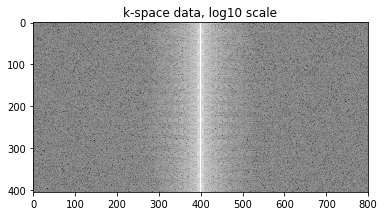

In [8]:
# plot the k-space data on log-scale
kdata_numpy = np.reshape(kdata.numpy(), (2, nspokes, spokelength))
kdata_numpy = kdata_numpy[0] + 1j*kdata_numpy[1]
plt.imshow(np.log10(np.absolute(kdata_numpy)))
plt.gray()
plt.title('k-space data, log10 scale')
plt.show()

In [9]:
# adjnufft back
# method 1: no density compensation (blurry image)
image_blurry = adjnufft_ob(kdata, ktraj)

# method 2: use density compensation
dcomp = calculate_radial_dcomp_pytorch(nufft_ob, adjnufft_ob, ktraj).unsqueeze(0).unsqueeze(0)
image_sharp = adjnufft_ob(kdata * dcomp, ktraj)

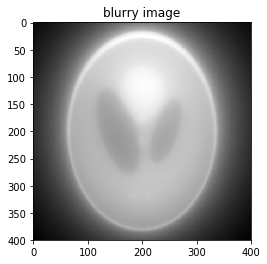

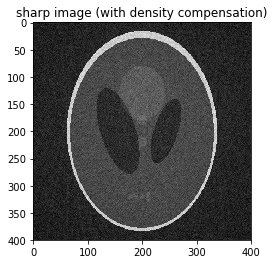

In [10]:
# show the images
image_blurry_numpy = np.squeeze(image_blurry.numpy())
image_blurry_numpy = image_blurry_numpy[0] + 1j*image_blurry_numpy[1]

image_sharp_numpy = np.squeeze(image_sharp.numpy())
image_sharp_numpy = image_sharp_numpy[0] + 1j*image_sharp_numpy[1]

plt.figure(0)
plt.imshow(np.absolute(image_blurry_numpy))
plt.gray()
plt.title('blurry image')

plt.figure(1)
plt.imshow(np.absolute(image_sharp_numpy))
plt.gray()
plt.title('sharp image (with density compensation)')

plt.show()